# Code adapted from: 
2021-05-14_sargassum_loading_Miron_ini

# Objective: test how to load initial time and position from Miron data

# Saving only d1 and d2 (fall within domain) , and type 0 ,1 , 6

# Types of drifters:
- 0: svp without drogue
- 1: sargassum-like mats    
- 2: small sphere 
- 3: square
- 4: cube
- 5: large sphere
- 6: svp

In [1]:
%pylab inline
from parcels import FieldSet, ParticleSet, JITParticle, Variable, AdvectionRK4
import numpy as np
import xarray as xr
from datetime import timedelta as delta
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Data explanation:


*Globcurrent products:
* e.g. /data/oceanparcels/input_data/GlobCurrent/v3p0/global_025_deg/total_hs_dailymean/20020101-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v03.0-fv01.0.nc
<BR> —> eastward_eulerian_current_velocity:long_name = "Absolute geostrophic velocity + hs depth Ekman velocity: zonal component" ;
* /data/oceanparcels/input_data/GlobCurrent/v3p0/global_025_deg/geostrophic_dailymean/20080630000000-GLOBCURRENT-L4-CURgeo_0m-ALT_OI-v03.0-fv01.0.nc
<BR> —> northward_geostrophic_current_velocity:long_name = "Absolute geostrophic velocity: meridian component" ;
* /data/oceanparcels/input_data/GlobCurrent/v3p0/global_025_deg/ekman_hs_dailymean/20080702-GLOBCURRENT-L4-CURekm_hs-ERAWS_EEM-v03.0-fv01.0.nc 
<BR> —> eastward_ekman_current_velocity:long_name = "hs depth Ekman current velocity: zonal component

# --> edit

# Dates sargassum:

In [2]:
nyears = [2018] #05, 2006, 2007, 2008, 2009, 2010]

In [3]:
import cartopy
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry
from collections import namedtuple
from shapely.geometry.polygon import LinearRing

In [4]:
Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

region = Region(
    region_name="all_region",
    lonmin = -99.,
    lonmax = -46.,
    latmin = 5.0,
    latmax = 30.,
)

# Data Miron:

In [5]:
!ls /data/oceanparcels/input_data/Miron_etal_2020/data/d1/

type-0_id-4101647.csv  type-2_id-2590476.csv  type-4_id-2588708.csv
type-1_id-2591504.csv  type-2_id-2591063.csv  type-4_id-2590451.csv
type-1_id-2593999.csv  type-2_id-2591947.csv  type-4_id-2592310.csv
type-1_id-2594008.csv  type-3_id-2588737.csv  type-5_id-2591095.csv
type-2_id-2587305.csv  type-3_id-2590475.csv  type-6_id-4101642.csv


# Join date and time using:
https://towardsdatascience.com/all-the-pandas-read-csv-you-should-know-to-speed-up-your-data-analysis-1e16fe1039f3 
    --> 

In [6]:
df = pd.read_csv('/data/oceanparcels/input_data/Miron_etal_2020/data/d1/' + 'type-1_id-2591504.csv',
                 parse_dates=[['date', 'time']])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 3 columns):
date_time    182 non-null datetime64[ns]
longitude    182 non-null float64
latitude     182 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.3 KB


# --> now have to convert to julian days like Clements format, if not can do the opposite ( Clement's data to this format (gregorian)):


In [7]:
df['date_time'][0]

Timestamp('2018-03-12 06:59:59')

In [8]:
date_time_obj = datetime.strptime(str(df['date_time'][0]), '%Y-%m-%d %H:%M:%S')

In [9]:
date_time_obj

datetime.datetime(2018, 3, 12, 6, 59, 59)

# --> cool!

# Load all the type 1 (sargassum like) drifter:

In [10]:
filedir_Miron = '/data/oceanparcels/input_data/Miron_etal_2020/data/'

In [11]:
drifters_list_d1 = [filedir_Miron + 'd1/' + 'type-1_id-2591504.csv',
                    filedir_Miron + 'd1/' + 'type-1_id-2593999.csv',
                    filedir_Miron + 'd1/' + 'type-1_id-2594008.csv',
                    filedir_Miron + 'd1/' + 'type-0_id-4101647.csv', 
                    filedir_Miron + 'd1/' + 'type-6_id-4101642.csv']

In [12]:
drifters_list_d2 = [filedir_Miron + 'd2/' + 'type-1_id-2588728.csv',
                    filedir_Miron + 'd2/' + 'type-1_id-2590462.csv',
                    filedir_Miron + 'd2/' + 'type-1_id-2592045.csv',
                    filedir_Miron + 'd2/' + 'type-0_id-4101644.csv',
                    filedir_Miron + 'd2/' + 'type-6_id-4101643.csv']

In [13]:
drifters_list = [drifters_list_d1, drifters_list_d2]

/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2591504.csv
2018-03-12 06:59:59
End time:  2018-06-15 05:39:00
-61.719269999999995
23.67091
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2593999.csv
2018-03-12 07:01:00
End time:  2018-07-03 04:32:59
-61.714690000000004
23.672320000000003
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2594008.csv
2018-03-12 06:41:00
End time:  2018-07-16 18:56:59
-61.72165
23.67163
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-0_id-4101647.csv
2018-03-11 12:00:00
End time:  2018-07-04 15:59:59
-61.728
23.518
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-6_id-4101642.csv
2018-03-11 12:00:00
End time:  2018-10-01 02:00:00
-61.729
23.518
/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2588728.csv
2018-03-16 19:16:00
End time:  2018-08-21 12:05:59
-46.05185
21.27587
/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2590462.csv
2018-03-16 19:13:00
End ti

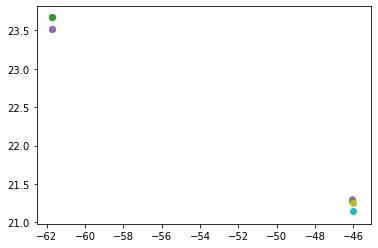

In [34]:
for drifters_point in drifters_list:
    for drifter in drifters_point:
        print(drifter)
        df = pd.read_csv(drifter, parse_dates=[['date', 'time']])
        df = df[(df["longitude"] > region.lonmin) & (df["longitude"] < region.lonmax) & (df["latitude"] > region.latmin) & (df["latitude"] < region.latmax)]
        print(df['date_time'].iloc[0])
        print('End time: ', df['date_time'].iloc[-1])
        print(df['longitude'].iloc[0])
        print(df['latitude'].iloc[0])
        plt.scatter(df['longitude'].iloc[0], df['latitude'].iloc[0])

/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2591504.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2593999.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2594008.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-0_id-4101647.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-6_id-4101642.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2588728.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2590462.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2592045.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-0_id-4101644.csv
/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-6_id-4101643.csv


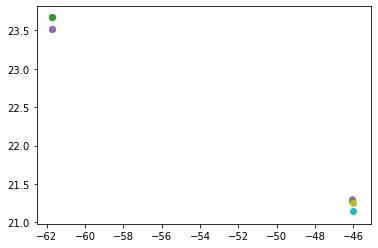

In [51]:
launch_times = []
launch_lons = []
launch_lats = []
launch_ids = []

for drifters_point in drifters_list:
    for drifter in drifters_point:
        print(drifter)
        df = pd.read_csv(drifter, parse_dates=[['date', 'time']])
        df = df[(df["longitude"] > region.lonmin) & (df["longitude"] < region.lonmax) & (df["latitude"] > region.latmin) & (df["latitude"] < region.latmax)]

        launch_times.append(str(df['date_time'].iloc[0]))
        launch_lons.append(df['longitude'].iloc[0])
        launch_lats.append(df['latitude'].iloc[0])
        launch_ids.append(drifter.split('.')[0].split('-')[-1])
        plt.scatter(df['longitude'].iloc[0], df['latitude'].iloc[0])

In [52]:
launch_times

['2018-03-12 06:59:59',
 '2018-03-12 07:01:00',
 '2018-03-12 06:41:00',
 '2018-03-11 12:00:00',
 '2018-03-11 12:00:00',
 '2018-03-16 19:16:00',
 '2018-03-16 19:13:00',
 '2018-03-16 19:16:00',
 '2018-03-16 11:00:00',
 '2018-03-23 09:59:59']

In [53]:
launch_lons

[-61.719269999999995,
 -61.714690000000004,
 -61.72165,
 -61.728,
 -61.729,
 -46.05185,
 -46.048429999999996,
 -46.052609999999994,
 -46.00899999999999,
 -46.003]

In [39]:
launch_ids

['2591504', '2593999', '2594008', '2588728', '2590462', '2592045']

In [54]:
np.savez('Miron_type-0-1-6_d1-d2_ini.npz', launch_times = launch_times, launch_lons = launch_lons
         , launch_lats = launch_lats, launch_ids = launch_ids) 

In [14]:

from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors 

import cartopy
import cartopy.crs as ccrs
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [15]:
def add_sub_region_box(ax, subregion):
    """ Source
    https://stackoverflow.com/questions/55303911/add-polygon-box-to-cartopy-python
    https://groups.google.com/g/scitools-iris/c/LxR0EbQolyE?pli=1
    """
    geom = geometry.box(minx=subregion.lonmin,maxx=subregion.lonmax,miny=subregion.latmin,maxy=subregion.latmax)
    ax.add_geometries([geom], crs=cartopy.crs.PlateCarree(), edgecolor='r', facecolor='None', linewidth=3) # , alpha=0.3
    return ax

# Have to adapt it to the first location of drifter that falls in domain for d3 and d4 as their inital positions fall out of the domain 
--> Northeast Extension cruise in the North Atlantic on 11 (1), 14 (2), 20 (3), and 28 (4) March 2018. (d1 to d4 from left to right)

/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2591504.csv


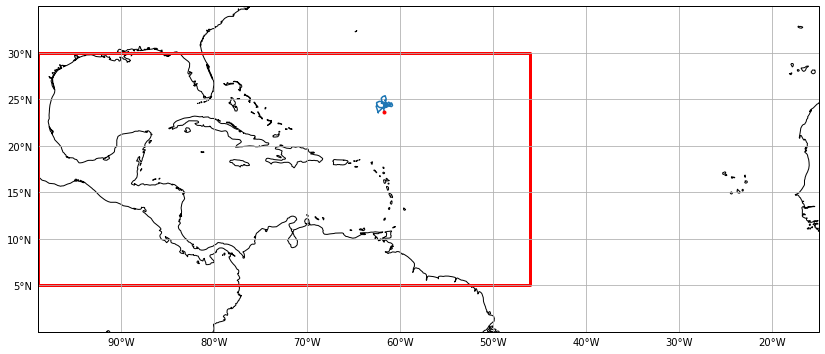

/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2593999.csv


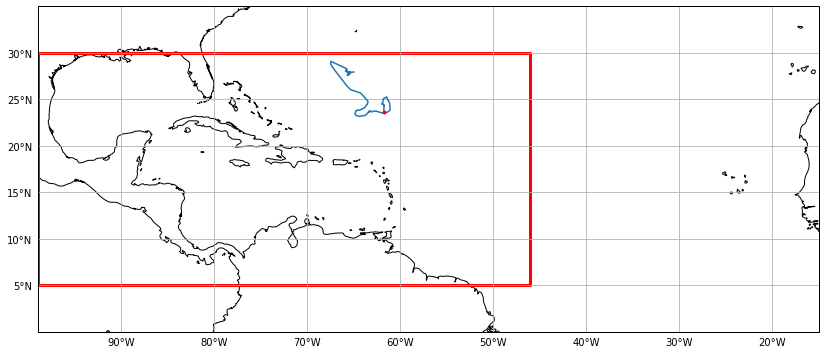

/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-1_id-2594008.csv


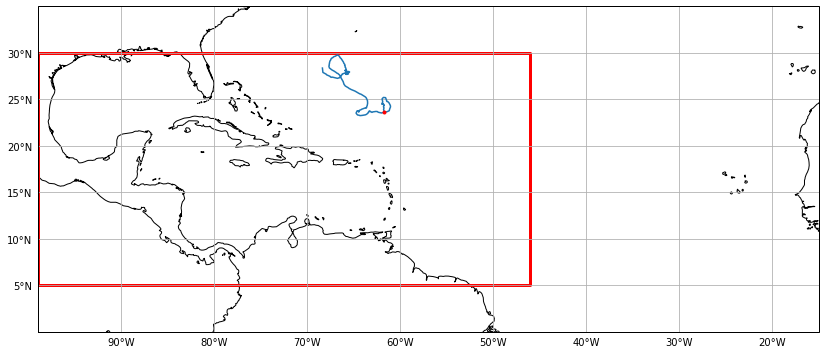

/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-0_id-4101647.csv


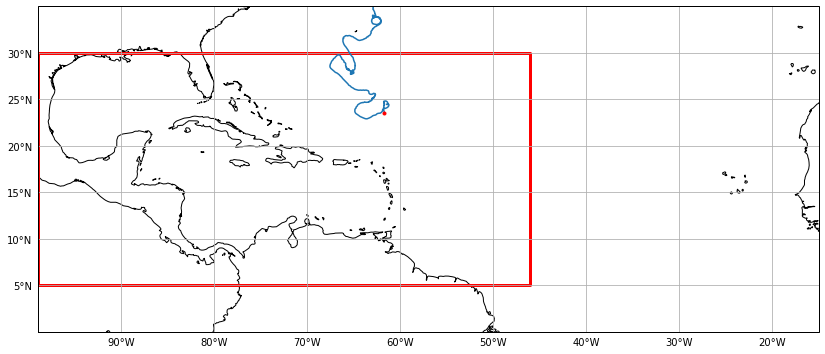

/data/oceanparcels/input_data/Miron_etal_2020/data/d1/type-6_id-4101642.csv


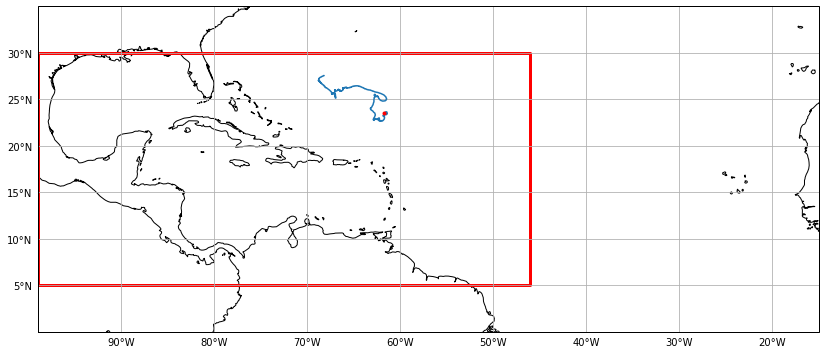

/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2588728.csv


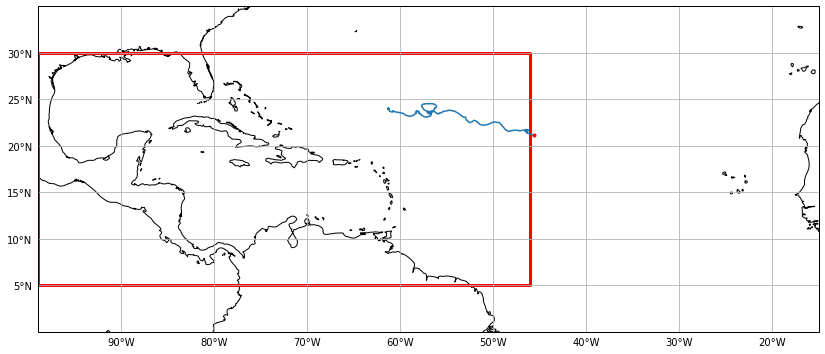

/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2590462.csv


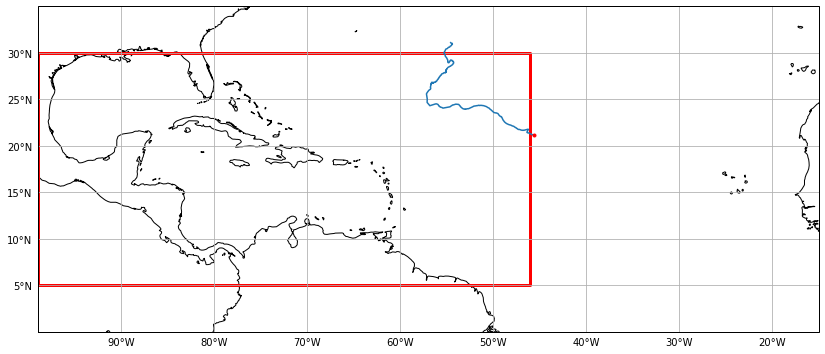

/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-1_id-2592045.csv


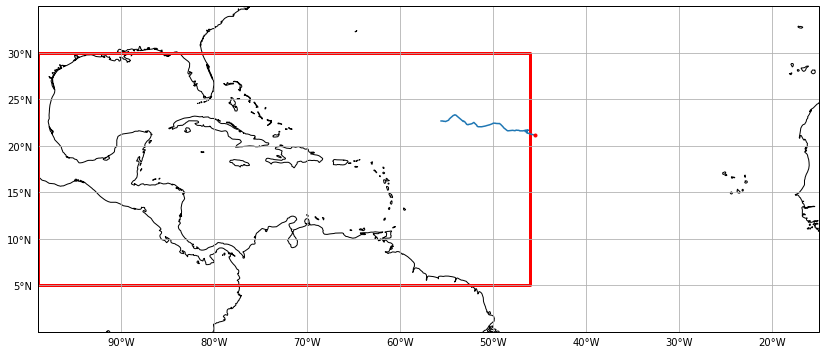

/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-0_id-4101644.csv


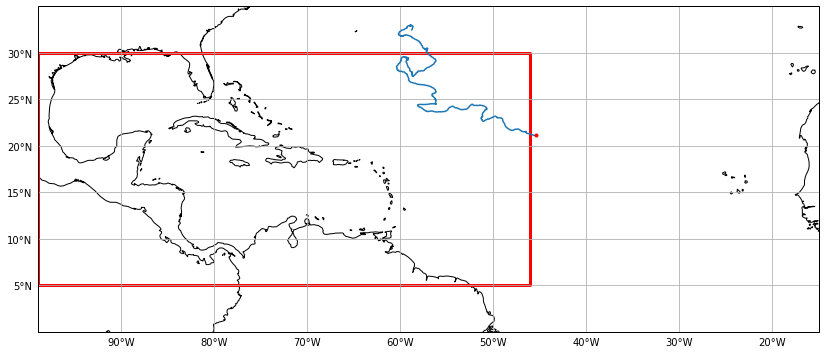

/data/oceanparcels/input_data/Miron_etal_2020/data/d2/type-6_id-4101643.csv


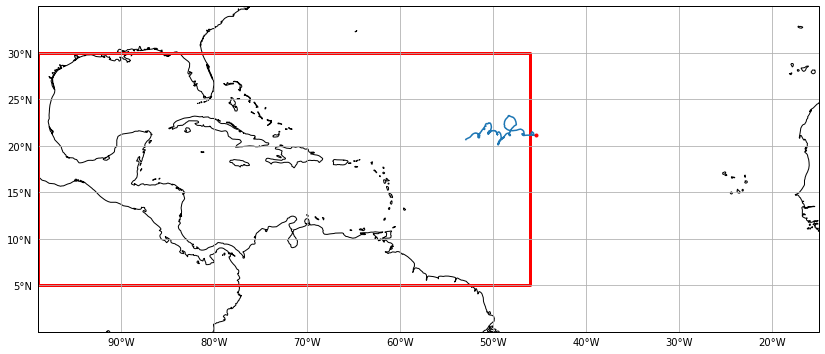

In [17]:
for drifters_point in drifters_list:
    for drifter in drifters_point:
        print(drifter)
        df = pd.read_csv(drifter, parse_dates=[['date', 'time']])

        plt.figure(figsize=(14,10)) #(17,5)
        ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
        ax1.coastlines(resolution='50m')
        #ax1.add_feature(cartopy.feature.LAND, facecolor='black')
        plt.plot(df['longitude'], df['latitude'], '-', transform=ccrs.PlateCarree()) #marker='o'
        plt.plot(df['longitude'][0], df['latitude'][0], '.r', transform=ccrs.PlateCarree()) #marker='o'
        ax1.set_xlim([-99, -15])
        ax1.set_ylim([0., 35])
        add_sub_region_box(ax1, region)
        
        gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        plt.show()
        


In [18]:
dz = np.load('Miron_type-0-1-6_d1-d2_ini.npz')

In [19]:
dz['launch_lons']

array([-61.71927, -61.71469, -61.72165, -61.728  , -61.729  , -46.05185,
       -46.04843, -46.05261, -46.009  , -46.003  ])

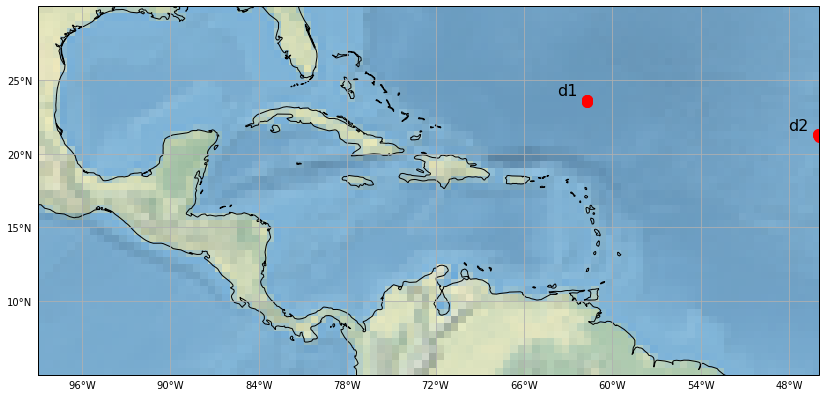

In [21]:
plt.figure(figsize=(14,10)) #(17,5)

###################
# Non-tidal:

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(dz['launch_lons'], dz['launch_lats'], s=100, c='r', transform=ccrs.PlateCarree()) #marker='o'
ax1.text(dz['launch_lons'][0]-2, dz['launch_lats'][0]+.3, 'd1', transform=ccrs.PlateCarree(), size=16)
ax1.text(dz['launch_lons'][5]-2, dz['launch_lats'][5]+.3, 'd2', transform=ccrs.PlateCarree(), size=16)
ax1.set_xlim([-99, -46])
ax1.set_ylim([5, 30])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

gl.xlabels_top = False
gl.ylabels_right = False
# #gl.xlines = False
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
#gl.xlocator = mticker.FixedLocator([-90, -80, -70, -60, -50, -40, -30, -20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


ax1.stock_img()



# Widening a bit eastern border:

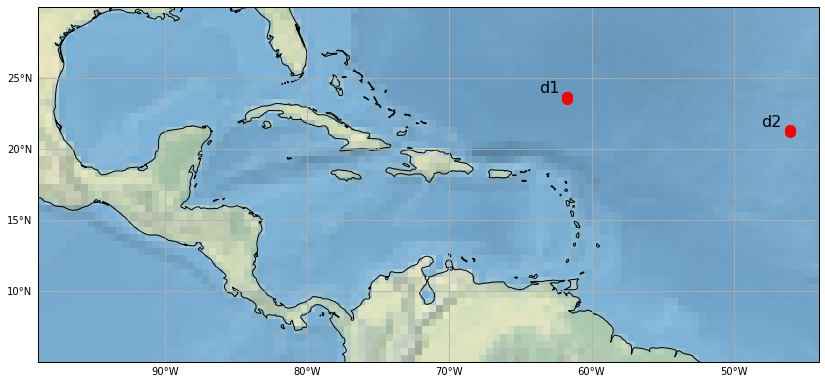

In [22]:
plt.figure(figsize=(14,10)) #(17,5)

###################
# Non-tidal:

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(dz['launch_lons'], dz['launch_lats'], s=100, c='r', transform=ccrs.PlateCarree()) #marker='o'
ax1.text(dz['launch_lons'][0]-2, dz['launch_lats'][0]+.3, 'd1', transform=ccrs.PlateCarree(), size=16)
ax1.text(dz['launch_lons'][5]-2, dz['launch_lats'][5]+.3, 'd2', transform=ccrs.PlateCarree(), size=16)
ax1.set_xlim([-99, -44])
ax1.set_ylim([5, 30])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

gl.xlabels_top = False
gl.ylabels_right = False
# #gl.xlines = False
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
#gl.xlocator = mticker.FixedLocator([-90, -80, -70, -60, -50, -40, -30, -20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


ax1.stock_img()


# --> fix above plot

# --> idea, for sargassum need to see if better to add drag to 0m drift, or ro add drift to 15m

# Release location plots:

## Location d1:

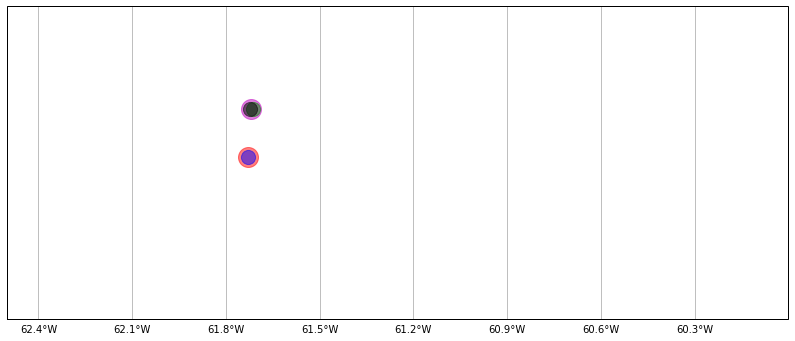

In [26]:
plt.figure(figsize=(14,10)) #(17,5)

###################
# Non-tidal:

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(dz['launch_lons'][0], dz['launch_lats'][0], s=400, c='m', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][1], dz['launch_lats'][1], s=200, c='g', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][2], dz['launch_lats'][2], s=200, c='k', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][3], dz['launch_lats'][3], s=400, c='r', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][4], dz['launch_lats'][4], s=200, c='b', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'

ax1.set_xlim([-62.5, -60]) #
ax1.set_ylim([23., 24.])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

gl.xlabels_top = False
gl.ylabels_right = False
# #gl.xlines = False
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
#gl.xlocator = mticker.FixedLocator([-90, -80, -70, -60, -50, -40, -30, -20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


## Location d2:

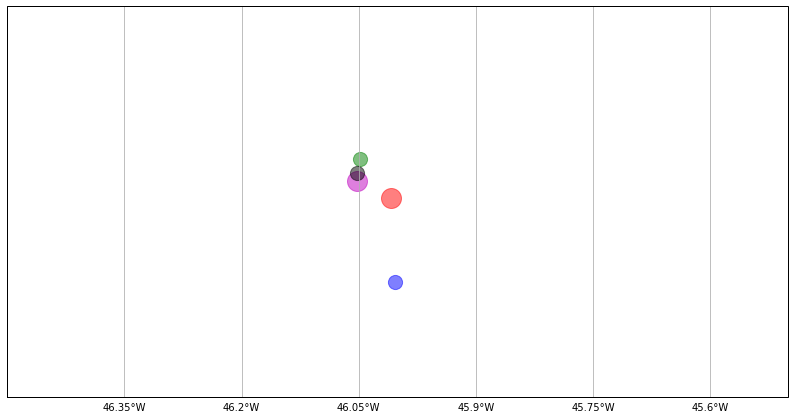

In [29]:
plt.figure(figsize=(14,10)) #(17,5)

###################
# Non-tidal:

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(dz['launch_lons'][5], dz['launch_lats'][5], s=400, c='m', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][6], dz['launch_lats'][6], s=200, c='g', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][7], dz['launch_lats'][7], s=200, c='k', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][8], dz['launch_lats'][8], s=400, c='r', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(dz['launch_lons'][9], dz['launch_lats'][9], s=200, c='b', alpha=.5, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([-46.5, -45.5]) #
ax1.set_ylim([21, 21.5])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

gl.xlabels_top = False
gl.ylabels_right = False
# #gl.xlines = False
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
#gl.xlocator = mticker.FixedLocator([-90, -80, -70, -60, -50, -40, -30, -20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}



# --> not really worth plotting them separately

# Plot d1 and d2 type1, 0, and 6 drifters

* d1:

In [ ]:

plt.figure(figsize=(14,10)) #(17,5)
ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])


ax1.scatter(dz['launch_lons'], dz['launch_lats'], s=100, c='r', transform=ccrs.PlateCarree()) #marker='o'
ax1.text(dz['launch_lons'][0]+2.2, dz['launch_lats'][0]+.3, 'd1', transform=ccrs.PlateCarree(), size=16)
ax1.text(dz['launch_lons'][3]+2.2, dz['launch_lats'][3]+.3, 'd2', transform=ccrs.PlateCarree(), size=16)
ax1.text(dz['launch_lons'][6]+2.2, dz['launch_lats'][6]+.3, 'd3', transform=ccrs.PlateCarree(), size=16)
ax1.text(dz['launch_lons'][9]+2.2, dz['launch_lats'][9]+.3, 'd4', transform=ccrs.PlateCarree(), size=16)

ax1.set_xlim([-100.1, -15])
ax1.set_ylim([-1., 35.1])
add_sub_region_box(ax1, region, color='k')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
        
for drifters_point in drifters_list:
    for drifter in drifters_point:
        print(drifter)
        df = pd.read_csv(drifter, parse_dates=[['date', 'time']])

        plt.plot(df['longitude'], df['latitude'], '-', transform=ccrs.PlateCarree()) #marker='o'

        
plt.show()
plt.close()
    

* d2: